# Variables Demograficas

- [ ] El tener multiples caracterisiticas demograficas permite hacer cortes y el sesgo...

In [1]:
import os
import re
import ast
import pandas as pd
import seaborn

import helpers.preprocess_text as pre_text
import helpers.preprocess_location as pre_loc
from helpers.here_api import normalize_user_location_here_api

## Geolocalización



### Objeto geo del tweet

In [ ]:
# Cargar tweets del dataset ejemplo
df_tweets = pd.read_json("./files/1_dataset.jsonl", lines=True)
df_tweets = df_tweets[['id', 'author_id', 'geo']]

# Cargar los objetos anidados geo
df_geo = pd.DataFrame(list(df_tweets['geo']))
df_geo = df_geo.drop(columns=['id'])
# df_geo.columns = list(map(lambda x: f"geo_{x}", df_geo.columns))

df_tweets = df_tweets.drop(columns=['geo'])
df_tweets = df_tweets.join(df_geo)

del df_geo

df_tweets

- [ ] Describir la funcion

In [ ]:
def normalize_twitter_geolocation(df_data):

    # TODO: Make this a wrapper(?)
    df_countries = pd.read_csv(f"./resources/countries_data.csv",
                               usecols=['ISO_2', 'ISO_3', 'name_short_es'],
                               sep='\t')

    ISO_codes = dict(df_countries.iloc[:, :2].values)
    countries_names = dict(df_countries.iloc[:, [0, 2]].values)

    # Normalize author country data
    srs_country_codes = df_data['country_code']
    df_data['country_code'] = srs_country_codes.map(ISO_codes)
    df_data['country_name'] = srs_country_codes.map(
        countries_names)

    # Normalize federal divisions
    admin_index = (df_data['place_type'] == 'admin')
    df_data['federal_division'] = df_data[admin_index]['name']

    # Normalize cities
    city_index = (df_data['place_type'] == 'city')
    df_data['city'] = df_data[city_index]['name']
    
    # Get bbox centroid
    df_data['geo_type'] = df_data['geo'].apply(lambda x: x['type'])
    df_data['geo_bbox'] = df_data['geo'].apply(lambda x: x['bbox'])
    df_data['latitude'] = df_data['geo_bbox'].apply(lambda x: (x[1]+x[3])/2)
    df_data['longitude'] = df_data['geo_bbox'].apply(lambda x: (x[0]+x[2])/2)

    return df_data

In [ ]:
df_ids = df_tweets[['id', 'place_id']]
df_ids

In [ ]:
df_geolocs = df_tweets.iloc[:, 1:].dropna(subset=['place_id']) \
                      .drop_duplicates(subset=['place_id'])
df_geolocs = normalize_twitter_geolocation(df_geolocs)
df_geolocs = df_geolocs[['place_id', 'country_code', 
                         'country_name', 'federal_division', 'city', 
                         'latitude', 'longitude']]
df_geolocs

In [ ]:
df_geo = df_ids.merge(df_geolocs, on='place_id', how='left')
df_geo = df_geo[~df_geo['country_code'].isna()]
df_geo

### Atributo *location* del usuario

In [ ]:
# Cargar tweets del dataset ejemplo
df_tweets = pd.read_json("./files/2_dataset.jsonl", lines=True)
df_tweets = df_tweets[['id', 'author_id', 'author']]

# Cargar los objetos anidados geo
df_authors = pd.DataFrame(list(df_tweets['author']))
df_authors = df_authors[['location', 'description']]
df_authors.columns = list(map(lambda x: f"author_{x}", df_authors.columns))

df_tweets = df_tweets.drop(columns=['author'])
df_tweets = df_tweets.join(df_authors)

del df_authors

df_tweets

In [ ]:
# Dejar solo los textos de locations sin duplicados ni nulos
df_unique_locs = df_tweets[['author_location']].drop_duplicates() \
                                        .dropna() \
                                        .reset_index(drop=True) \
                                        .copy()
df_unique_locs['author_location_processed'] = df_unique_locs['author_location']

# Preprocesar los strings de locations
df_unique_locs = pre_loc.preprocessing_location_string(df_unique_locs)
df_unique_locs

In [ ]:
df_unique_locs = df_unique_locs[['author_location_processed']].drop_duplicates() \
                                                              .reset_index(drop=True).copy()

# Validar locations ya preprocesadas
df_unique_locs = pre_loc.validate_author_locations(df_unique_locs.copy())
df_unique_locs = df_unique_locs[df_unique_locs['author_location_is_valid']].reset_index(drop=True)
df_unique_locs

In [ ]:
df_prev =  pd.read_csv('./resources/user_location_none.csv',
                       usecols=['a_proc_loc'])
df_prev = df_prev.append(pd.read_csv('./resources/user_location_invalids.csv',
                                     usecols=['a_proc_loc']))
df_prev = df_prev.append(pd.read_csv('./resources/user_location_valids.csv',
                                     usecols=['a_proc_loc']))
df_prev

In [ ]:
df_unique_locs = df_unique_locs[~df_unique_locs['author_location_processed'].isin(df_prev['a_proc_loc'])]
df_unique_locs = df_unique_locs.reset_index(drop=True)
df_unique_locs

- [ ] Explicar que es la API de HERE y de que nos ayuda

In [ ]:
CREDENTIALS_HERE_API = "<API_KEY>"

In [ ]:
df_data_locs, df_invalids_locs, df_none_locs = normalize_user_location_here_api(df_unique_locs, CREDENTIALS_HERE_API)

### Store the new normalized locations

In [ ]:
try:
    df_prev_valid = pd.read_csv('./resources/user_location_valids.csv')
    df_data_locs_tmp = df_data_locs[['author_location_processed', 'norm_country_code', 
                        'norm_country', 'norm_fed_division', 'norm_fed_division_code', 
                        'norm_county', 
                        'norm_city', 'norm_district', 'norm_postal_code', 
                        'norm_latitude', 'norm_longitude',
                        'here_query_score', 'here_field_score', 'valid_regions']]
    df_data_locs_tmp.columns = df_prev_valid.columns
    df_prev_valid = pd.concat([df_prev_valid, df_data_locs_tmp])
    df_prev_valid = df_prev_valid.drop_duplicates('a_proc_loc', keep='last')
    
    
    
except FileNotFoundError:
    df_prev_valid = df_data_locs.copy()

df_prev_valid.to_csv('./resources/user_location_valids.csv', index=False)

### Assign the normalized author locations to the tweets

In [ ]:
df_valid = pd.read_csv('./resources/user_location_valids.csv',
                       usecols=['a_proc_loc', 'a_code', 'a_country',
                                'a_fdiv', 'a_county', 'a_city',
                                'a_lat', 'a_lng'])
df_valid

In [ ]:
df_data = df_tweets[['id', 'author_location']].copy()
df_data = df_data.dropna(subset='author_location') \
                 .reset_index(drop=True)
df_data['author_location_processed'] = df_data['author_location'].copy()
df_data = pre_loc.preprocessing_location_string(df_data)
df_data

In [ ]:
df_norm = df_data.merge(df_valid, left_on='author_location_processed',
                        right_on='a_proc_loc', how='left')
df_norm = df_norm.dropna(subset=['a_code'])
df_norm = df_norm.reset_index(drop=True) \
                 .drop(columns=['a_proc_loc', 
                                'author_location_processed'])
df_norm.columns = ['id', 'author_location',
                   'country_code', 'country', 'federal_division', 'county', 
                   'city', 'latitude', 'longitude']
df_norm

In [ ]:
df_norm = df_norm[df_norm['country_code'].isin(['MEX', 'ARG', 'COL'])]
df_norm

In [ ]:
df_norm['country'].value_counts()

- [ ] Graficas juntando ambos metodos

- [ ] Ideas para extraer más locations

## Inferir género

El poder asignar un género a los tweets nos permite hacer un estudio de como los diferentes géneros abordan el tema de estudio, en este caso el de Migración. Twitter no recolecta esa información al hacer la cuenta, por lo que no podemos encontrar un atributo dado por la API, pero al igual que la geolocalización, podemos inferirla a partir de atributos como el nombre, la descripción o incluso de la foto de perfil.

En esta notebook se van a revisar algunas opciones para asignar género al autor:
- Buscar nombres típicamente masculinos o femeninos en los campos de username, descripción
- Buscar pronombres (She/Her o He/His) en la descripción del usuario
- Buscar la nacionalidad (e.g.: Mexicano / Mexicana) en los campos descripción

También se podría trabajar con adjetivos, profesiones, oficios o títulos.

Nota: Dado que estos campos son abiertos y el nivel de veracidad recae completamente en cada usuario, se puede esperar que estos métodos tengan falsos positivos o negativos. Igualmente, tampoco se puede esperar que se termine asignando un género a todos los autores.

## Cargar nombres, pronombres, nacionalidades y géneros

En el directorio llamado ./resources hay un archivo llamado names_genders.csv que contiene una columna con nombres, una con el género que típicamente tienen las personas llamadas así y una última columna de si es un nombre compuesto como; Maria Jose o Jose Guadalupe.

In [2]:
df_names = pd.read_csv('./resources/names_genders.csv')

pre_text.remove_duplicated_chars(df_names, 'name')

# Names composed
df_names_double = df_names[df_names['is_double']]
regex_names_double = f"\\b((?:{'|'.join(df_names_double['name'])}))\\b"
regex_names_double = re.compile(regex_names_double)

# Single names
df_names_single = df_names[~df_names['is_double']]
regex_names_single = f"\\b((?:{'|'.join(df_names_single['name'])}))\\b"
regex_names_single = re.compile(regex_names_single)

# Names to gender
dict_names_gender = df_names.set_index('name')['gender'].to_dict()
df_names

,name,gender,is_double
0,guadalupe,F,False
1,jose,M,False
2,sofia,F,False
3,angel,M,False
4,jesus,M,False
...,...,...,...
555,aron,M,False
556,jose guadalupe,M,True
557,jose maria,M,True
558,maria guadalupe,F,True


Despues hay un diccionario con los posibles strings conteniendo pronombres y el genero que identifican. 

In [3]:
dict_pronouns_gender = {
    "she her": 'F',
    "her she": 'F',
    "he him": 'M',
    "him he": 'M'
}

regex_pronous = f"\\b((?:{'|'.join(dict_pronouns_gender.keys())}))\\b"
regex_pronous = re.compile(regex_pronous)
regex_pronous

re.compile(r'\b((?:she her|her she|he him|him he))\b', re.UNICODE)

Un diccionario con las posibles nacionalidades en las diferentes variaciones segun el genero

In [4]:
dict_nationalities_gender = {
    'mexicano': 'M',
    'mexicana': 'F',
    'colombiano': 'M',
    'colombiana': 'F',
    'argentino': 'M',
    'argentina': 'F'
}

regex_nationalities = f"\\b((?:{'|'.join(dict_nationalities_gender.keys())}))\\b"
regex_nationalities = re.compile(regex_nationalities)
regex_nationalities

re.compile(r'\b((?:mexicano|mexicana|colombiano|colombiana|argentino|argentina))\b',
re.UNICODE)

## Cargar tweets

Primero hay que cargar los tweets, específicamente el ID del tweet, el ID del usuario, el nombre del autor, su descripción. Los últimos tres campos son abiertos, es decir, que el usuario puede ingresar lo que desee a excepción de algunos caracteres especiales. Esto implica que antes de todo hay que pre-procesarlos para así reducir el número de variantes para una misma nacionalidad y/o nombre.

Nota: Usaremos de ejemplo el primer dataset que se obtuvo en la notebook "2_Definiendo_Queries.ipynb".

In [5]:
df_tweets = pd.read_json("./files/1_dataset.jsonl", lines=True)
df_tweets = df_tweets[['id', 'author_id', 'author']]

df_tweets['author_name'] = df_tweets['author'].apply(lambda x: x['name'])
df_tweets['author_description'] = df_tweets['author'].apply(lambda x: x['description'])

df_tweets = df_tweets.drop(columns=['author'])

Para evitar trabajar con autores duplicados, trabajaremos solo con una copia única de los autores, asignaremos géneros y luego haremos JOIN a los tweets usando como llave la columna `author_id`.

In [6]:
df_users = df_tweets.drop_duplicates(subset=['author_id'], 
                                  keep='last').reset_index(drop=True)
df_users = df_users.iloc[:, 1:]
df_users

,author_id,author_name,author_description
0,1361302057945333760,Activa,Somos una empresa industrial y comercial de la...
1,1391458758459600896,Jorge Araya,ver peliculas
2,1149464602452877312,Eduardo Cardoza Mata 🇸🇻🇦🇷,Embajador de El Salvador en Argentina. Salvado...
3,119160105,daniel tejeda,#Córdoba Tierra de Santos... https://t.co/eEp1...
4,805051335687081984,🇲🇽 MUCMAM-IMU MX 🏍️🛵,pero es el comportamiento del usuario quien te...
...,...,...,...
4634,377788360,Eduardo Díatri🤍💙❤️☮️💛💙,Productor y asociado para espectáculos mayores...
4635,397706715,FUVADIS INTERNACIONAL 🏳️‍🌈,"Trabajamos por la inclusión, el respeto y la i..."
4636,1176580744036196352,GaelAlejandro,¡Estoy vivooo!
4637,579360940,Juan Farre,#11


## Preprocesamiento

La siguiente función se encarga de pasar todo a minúsculas, eliminar acentos, URLs, emails, números, caracteres que no sean letras y espacios en blancos duplicados. Esto nos ayudará a que al buscar los nombres o nacionalidades en los campos, se tenga más posibilidades de encontrarlos, dado que no habrá variaciones del tipo: "NOE", "NoE", "Noe", "Noé". Permitiendo que todas esas variaciones sean validas y encontradas con la cadena de texto "noe".

In [7]:
def preprocess_for_names(df_data, new_col, flg_remove_two_chars=True):

    at_least_3_letter_reg = re.compile(r'\b\w{1,2}\b')
    at_least_3_letter_reg_capture = re.compile(r'\b(\w{2})\b')

    pre_text.initial_preprocessing(df_data, new_col,
                                   flg_remove_emojis=True,
                                   flg_lower=True)

    pre_text.remove_urls(df_data, new_col)
    pre_text.remove_emails(df_data, new_col)
    pre_text.remove_urls(df_data, new_col)
    pre_text.remove_numbers(df_data, new_col, 
                            replace_char=' ')

    pre_text.remove_duplicated_chars(df_data, new_col)
    pre_text.remove_non_alphanumeric(df_data, new_col)

    pre_text.remove_single_letters(df_data, new_col)
    
    if(flg_remove_two_chars):
        df_data[new_col] = df_data[new_col].str.replace(at_least_3_letter_reg, 
                                                        ' ', regex=True)

    pre_text.remove_multiple_blank_spaces(df_data, new_col)
    df_data[new_col] = df_data[new_col].str.strip()

    valid_texts = ((~df_data[new_col].isna()) *
                   (df_data[new_col] != '') *
                   (~df_data[new_col].str.contains(r'^\w$', regex=True)))
    df_data = df_data[valid_texts]

    return df_data

Se le aplica la función de limpieza a ambas columnas

In [8]:
df_users['author_name_og'] = df_users['author_name']
df_users = preprocess_for_names(df_users.copy(), 'author_name')
df_users = preprocess_for_names(df_users.copy(), 'author_description',
                                flg_remove_two_chars=False)
df_users[['author_name_og', 'author_name']]

,author_name_og,author_name
0,Activa,activa
1,Jorge Araya,jorge araya
2,Eduardo Cardoza Mata 🇸🇻🇦🇷,eduardo cardoza mata
3,daniel tejeda,daniel tejeda
4,🇲🇽 MUCMAM-IMU MX 🏍️🛵,mucmam imu
...,...,...
4633,Alfredo Marquez T.,alfredo marquez
4634,Eduardo Díatri🤍💙❤️☮️💛💙,eduardo diatri
4635,FUVADIS INTERNACIONAL 🏳️‍🌈,fuvadis internacional
4636,GaelAlejandro,gaelalejandro


## Buscar los nombres en la columna del nombre

In [9]:
# Copia de la tabla de usuarios
df_by_names = preprocess_for_names(df_users.copy(), 'author_name')

# Buscar nombres
df_tmp2 = df_by_names['author_name'].str.extract(regex_names_double).dropna()

df_tmp1 = df_by_names[~df_by_names.index.isin(df_tmp2.index)]['author_name']
df_tmp1 = df_tmp1.str.extract(regex_names_single).dropna()

# Asignar género en base al nombre encontrado
df_by_names['extracted_name'] = pd.concat([df_tmp1, df_tmp2])[0]
df_by_names['gender'] = df_by_names['extracted_name'].map(dict_names_gender)

df_by_names = df_by_names.dropna()
df_by_names[['author_name', 'extracted_name', 'gender']]

,author_name,extracted_name,gender
1,jorge araya,jorge,M
2,eduardo cardoza mata,eduardo,M
3,daniel tejeda,daniel,M
5,fabian neiman,fabian,M
11,rodolfo alcide,rodolfo,M
...,...,...,...
4629,agustin milan gomez,agustin,M
4630,agustin basilio,agustin,M
4632,jorge gomez monge,jorge,M
4633,alfredo marquez,alfredo,M


## Buscar los probombres en la descripción

In [10]:
# Descartar usuarios a los que ya se les asigno un género
df_pronouns = df_users[~df_users['author_id'].isin(df_by_names['author_id'])].copy()

# Buscar los probombres en la descripción
df_pronouns['extracted_pronoun'] = df_pronouns['author_description'].str.extract(regex_pronous).dropna()

# Asignar un género en base a los pronombres encontrados
df_pronouns['gender'] = df_pronouns.dropna()['extracted_pronoun'].map(dict_pronouns_gender)

df_pronouns = df_pronouns.dropna()
df_pronouns[['author_name', 'extracted_pronoun', 'gender']]

,author_name,extracted_pronoun,gender
526,celia mendoza,she her,F
752,vino barato,he him,M
1612,gabe itch,he him,M
1670,karol suarez,she her,F
1698,edecan telcel taylor version,he him,M
1768,lencha huasteca uta stan,she her,F
2206,pistolita,she her,F
2351,alain rodriguez castro,he him,M
2692,paz,she her,F
3634,raf juguito mengou,he him,M


### Nota
Los siguientes métodos necesitan un mayor preprocesamiento del realizado en esta notebook, debido a que puede haber nombres de países que se confundan con la nacionalidad (e.g. Argentina) o los usuarios sean de una organización y/o negocio, pero mencionen a alguna nacionalidad. Se debería considerar añadir un paso de preprocesamiento donde se intente identificar que cuentas no son controladas por un solo individuo y representan a un conjunto.

## Buscar nacionalidades en la descripción

In [11]:
# Descartar usuarios a los que ya se les asigno un género
df_nationalities = df_users.loc[~(df_users['author_id'].isin(df_by_names['author_id']) + 
                                  df_users['author_id'].isin(df_pronouns['author_id']))].copy()

# Buscar los probombres en la descripción
df_nationalities['extracted_nationality'] = df_nationalities['author_description'].str.extract(regex_nationalities).dropna()

# # Asignar un género en base a los pronombres encontrados
df_nationalities['gender'] = df_nationalities.dropna()['extracted_nationality'].map(dict_nationalities_gender)

df_nationalities = df_nationalities.dropna()
df_nationalities[['author_description', 'extracted_nationality', 'gender']]

,author_description,extracted_nationality,gender
49,donde el el tengan paz un vago lector sexoso i...,colombiano,M
52,argentina es inviable por los argentinos,argentina,F
90,cuenta oficial de la secretaria de la juventud...,argentina,F
96,hincha de river puxa asturias puxa bolos cuatr...,argentina,F
112,real embajada de noruega ante la republica arg...,argentina,F
...,...,...,...
4460,trabajamos para defender los derechos de las l...,argentina,F
4525,colombiano democrata amante de la naturaleza,colombiano,M
4528,astrologa poetisa viajera colombiana amo los a...,colombiana,F
4529,tucuman argentina dios patria familia lic admi...,argentina,F


## Buscar nombres en la descripción del usuario

In [12]:
# # Descartar usuarios a los que ya se les asigno un género
# df_description = df_users.loc[~(df_users['author_id'].isin(df_by_names['author_id']) + 
#                                 df_users['author_id'].isin(df_pronouns['author_id']) + 
#                                 df_users['author_id'].isin(df_nationalities['author_id']))].copy()

# # Extraer nombres de la descripción
# df_tmp2 = df_description['author_description'].str.extract(regex_names_double).dropna()

# df_tmp1 = df_description[~df_description.index.isin(df_tmp2.index)]['author_description']
# df_tmp1 = df_tmp1.str.extract(regex_names_single).dropna()

# # Asignar genero a los nombres
# df_description['extracted_name'] = pd.concat([df_tmp1, df_tmp2])[0]
# df_description['gender'] = df_description['extracted_name'].map(dict_names_gender)

# df_description = df_description.dropna()
# df_description[['author_description', 'extracted_name', 'gender']]

## Añadir la columna gender a cada tweet

Primero se juntan las tablas de los usuarios con género obtenidos con los diferentes métodos

In [14]:
df_genders = pd.concat([df_by_names, df_pronouns, df_nationalities])
df_genders = df_genders.drop(columns=['extracted_name', 'extracted_pronoun', ])

df_genders = df_genders[['author_id', 'gender']]
df_genders.columns = ['author_id', 'author_gender']
df_genders

,author_id,author_gender
1,1391458758459600896,M
2,1149464602452877312,M
3,119160105,M
5,705239258148290560,M
11,1385219885891047424,M
...,...,...
4460,1166728119434301440,F
4525,317321263,M
4528,1402075690019786752,F
4529,1146517522927280128,F


Se hace el merge de las tablas, el equivalente a un JOIN de SQL

In [15]:
df_tweets = df_tweets.merge(df_genders, on='author_id', how='left')

<AxesSubplot:ylabel='author_gender'>

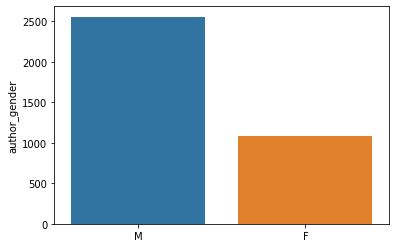

In [16]:
seaborn.barplot(x=df_tweets['author_gender'].value_counts().index, 
                y=df_tweets['author_gender'].value_counts())

In [17]:
df_tweets['author_gender'] = df_tweets['author_gender'].fillna('NaN')

In [18]:
df_tweets['author_gender'].value_counts()

NaN    5121
M      2559
F      1089
Name: author_gender, dtype: int64

## Más ideas
- Buscar profesiones y sus abstracciones en el nombre del la cuenta. E.g.: Doctor/Dr. y Doctora/Dra.
- Buscar titulos como "Papá", "Mamá", "Coordinador", "Coordinadora"
- Buscar adjetivos calificativos en la descripción
- Identificar cuentas que representen a Secretarias Publicas, Oraganización, Clubs, Empresas, etc.
- Aplicar un NER para hacer las busquedas de manera más inteligentes y focalizada